**Feature Engineering**
==========
모델에 직접 적용하기 전에 데이터들을 분석하고 이를 training하기 좋게 변환하는 과정이 중요하다 생각하여 하는 과정임 - Sina의 Kernel 참조하였음

In [88]:
%matplotlib inline
import numpy as np
import pandas as pd
import re as re
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics 
import seaborn as sns
warnings.filterwarnings(action='ignore')

In [89]:
train = pd.read_csv('C:/Users/sangkyu/git/kaggle/titanic/input/train.csv')
test = pd.read_csv('C:/Users/sangkyu/git/kaggle/titanic/input/test.csv')
full_data = [train,test]

In [90]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [91]:
train[['Pclass','Survived']].groupby(['Pclass'],as_index=False).mean()
# as_index=True로 설정하게되면 보기 불편하게 되어있음

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [92]:
train[['Sex','Survived']].groupby(['Sex'],as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [93]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)

print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.517544
1   (16.0, 32.0]  0.364444
2   (32.0, 48.0]  0.356275
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


In [94]:
train['Age']

0      22
1      38
2      26
3      35
4      35
5      29
6      54
7       2
8      27
9      14
10      4
11     58
12     20
13     39
14     14
15     55
16      2
17     30
18     31
19     25
20     35
21     34
22     15
23     28
24      8
25     38
26     37
27     19
28     17
29     36
       ..
861    21
862    48
863    34
864    24
865    42
866    27
867    31
868    42
869     4
870    26
871    47
872    33
873    47
874    28
875    15
876    20
877    19
878    19
879    56
880    25
881    33
882    22
883    28
884    25
885    39
886    27
887    19
888    43
889    26
890    32
Name: Age, Length: 891, dtype: int32

In [95]:
train[['SibSp','Survived']].groupby(['SibSp'],as_index=False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [96]:
train[['Parch','Survived']].groupby(['Parch'],as_index=False).mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [97]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
train[['FamilySize','Survived']].groupby(['FamilySize'],as_index=False).mean()
# FamilySize라는 Feature가 언뜻보면 생존에 영향을 끼치는 것 같기도 하다.

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [98]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']==1,'IsAlone']=1
train[['IsAlone','Survived']].groupby(['IsAlone'],as_index=False).mean()
# 혼자 배에 탔는지 안탔는지가 영향을 주는 것 같아 보인다.

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [99]:
# 어렵게 생각하지않고 Missing Value를 최빈값으로 채워 넣어야겠다.
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
train[['Embarked','Survived']].groupby(['Embarked'],as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [100]:
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# pd.qcut -> 동일한 개수로 나누기
train[['CategoricalFare','Survived']].groupby(['CategoricalFare'],as_index=False).mean()
# 높은 운임을 낸 사람이 조금 더 살아남은것으로 보임

,CategoricalFare,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [101]:
train['Name']
# 보면 이름이 중구난방으로 적혀있어...어떻게할까? 보면 Mr,Miss,Master,Mrs,Rev등으로 나누어짐
# 나는 외국이름을 나누는데 어떻게 나눠야할지 모르겠어..

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
5                                       Moran, Mr. James
6                                McCarthy, Mr. Timothy J
7                         Palsson, Master. Gosta Leonard
8      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                    Nasser, Mrs. Nicholas (Adele Achem)
10                       Sandstrom, Miss. Marguerite Rut
11                              Bonnell, Miss. Elizabeth
12                        Saundercock, Mr. William Henry
13                           Andersson, Mr. Anders Johan
14                  Vestrom, Miss. Hulda Amanda Adolfina
15                      Hewlett, Mrs. (Mary D Kingcome) 
16                                  Rice, Master. Eugene
17                          Wil

In [102]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name) or re.search(' ([A-Za-z]+).', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))


# 이름중에서 성만 따로 추출해서 'Title'이라는 새로운 Column을 만듬

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [103]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Capt','Col','Countess','Don','Dr','Jonkheer','Major',
                                                'Rev','Sir','Dona'],'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    
train[['Title','Survived']].groupby(['Title'],as_index=False).mean()

# 사람이 타이핑 하면서 오타가 난것들을 바꾸어주고 흔하지 않은 성을 Rare로 하나로 묶어 Survived와의 관계를 확인 하였다


,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [104]:
for dataset in full_data:
    # 'Sex' : 여자를 1 남자를 0으로 매핑하자
    dataset['Sex'] = dataset['Sex'].replace('female',0)
    dataset['Sex'] = dataset['Sex'].replace('male',1)
    # 'Title' : 5개로 나누어진 'Title'변수를 숫자로 매핑함
    dataset['Title'] = dataset['Title'].replace('Master',1)
    dataset['Title'] = dataset['Title'].replace('Miss',2)
    dataset['Title'] = dataset['Title'].replace('Mr',3)
    dataset['Title'] = dataset['Title'].replace('Mrs',4)
    dataset['Title'] = dataset['Title'].replace('Rare',5)

    # 'Embarked' C,Q,S로 나누어져있음 이걸 숫자로 매핑하자
    dataset['Embarked'] = dataset['Embarked'].replace('C',0)
    dataset['Embarked'] = dataset['Embarked'].replace('Q',1)
    dataset['Embarked'] = dataset['Embarked'].replace('S',2)
    # 'Fare' 구간을 숫자로 매핑하자
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare']<= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare']<= 31.0), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31.0, 'Fare'] = 3
    # 'Age' 구간을 숫자로 매핑하자
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
# Feature들중에서 필요없는건 지우고 필요한건 선택하여 train set을 완성하자.
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',
                 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)
print(train.shape)
print(test.shape)

(891, 8)
(418, 7)


In [105]:
train[['Fare','Survived','Pclass']].groupby(['Fare','Pclass'],as_index=False).mean()

,Fare,Pclass,Survived
0,0.0,1,0.000000
1,0.0,2,0.000000
2,0.0,3,0.208531
3,1.0,2,0.383721
4,1.0,3,0.259542
5,2.0,1,0.529412
6,2.0,2,0.600000
7,2.0,3,0.305556
8,3.0,1,0.685535
9,3.0,2,0.545455


In [106]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,0,3,1,1,0.0,2,0,3
1,1,1,0,2,3.0,0,0,4
2,1,3,0,1,1.0,2,1,2
3,1,1,0,2,3.0,2,0,4
4,0,3,1,2,1.0,2,1,3


In [107]:
test.fillna(test.mean(),inplace=True)

In [108]:
X=train.drop(columns=['Survived'],axis=1)
y=train['Survived']

In [109]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [110]:
%%time

import xgboost as xgb

model_xgb = xgb.XGBClassifier(max_depth=9, learning_rate=0.01, n_estimators=500, reg_alpah=1.1,
                             colsample_bytree=0.9, subsample=0.9, n_jobs=5)
model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False, early_stopping_rounds=50)
pred_test_xgb = model_xgb.predict(X_val)
score_test_xgb = metrics.accuracy_score(pred_test_xgb, y_val)
print("XGBoost Test score: ", score_test_xgb)

XGBoost Test score:  0.8324022346368715
Wall time: 108 ms


In [111]:
model_xgb.feature_importances_
from pandas import Series
feature_importance = model_xgb.feature_importances_
Series_feat_imp = Series(feature_importance, index=test.columns)

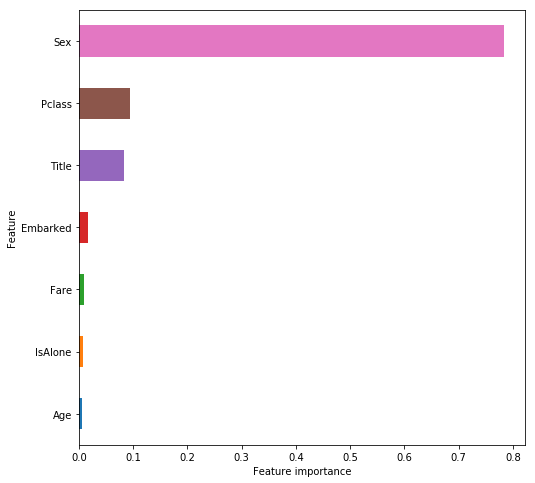

In [112]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [113]:
test_2 = pd.read_csv('C:/Users/sangkyu/git/kaggle/titanic/input/test.csv')

In [114]:
xgb_pred=model_xgb.predict(test)

In [115]:
result = pd.DataFrame(test_2['PassengerId'])
result['Survived']= xgb_pred

In [116]:
result.to_csv('submission13.csv', index=False)